# [Qwen2.5-7B] Experiment: Feature Manifold Replication in Sentences

## The Problem
Current Interpretability methods often rely on **Attention Heatmaps** to determine if a model is "moving information" from one part of a sentence to another. However, attention can be misleading (e.g., the "Attention Sink" phenomenon).

## The Hypothesis
If a model successfully copies information (e.g., a Date) from a source token to a destination token, the **Feature Manifold** (the geometric shape of that data) should appear at the destination.

## The Experiment
We will use **Supervised Multi-Dimensional Scaling (SMDS)** to detect the presence of a "Date Manifold" (a circular structure) at every single token in a sentence.

**The Pipeline:**
1.  **Generate Data:** Create hundreds of sentences with a fixed structure but varying dates (e.g., *"Alice was born on [Date]..."*).
2.  **Record Activations:** Pass these sentences through an LLM and save the hidden states for every token.
3.  **Apply SMDS:** Test every token position: *Does this token's activation space look like a circle?*

In [1]:
# Install necessary libraries if not present
# %pip install torch transformers numpy pandas tqdm matplotlib
import warnings
from tqdm import TqdmWarning
warnings.filterwarnings("ignore", category=TqdmWarning)
import torch
import numpy as np
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer

from tqdm import tqdm
import random
from datetime import datetime, timedelta

# Visualization settings
import matplotlib.pyplot as plt
%matplotlib inline

# Check for GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## Generate the data

We need a dataset where the **structure is identical** (so token $i$ always corresponds to the same word), but the **content (the date)** changes.

We will generate samples where:
1.  **$X$ (The Input):** A sentence mentioning a birthday.
2.  **$y$ (The Label):** The day of the year (0-365), normalized to $[0, 1]$.

In [2]:
def get_ordinal_date(n):
    """
    Converts int 13 -> string '13th', 1 -> '1st', etc.
    Necessary to make the sentence natural for the LLM.
    """
    if 11 <= (n % 100) <= 13:
        suffix = 'th'
    else:
        suffix = {1: 'st', 2: 'nd', 3: 'rd'}.get(n % 10, 'th')
    return f"{n}{suffix}"

def get_day_of_year(month, day):
    """Converts a month/day to a normalized float [0, 1]."""
    date = datetime(2023, month, day)
    day_of_year = date.timetuple().tm_yday - 1
    return day_of_year / 365.0

def generate_dataset(n_samples=500):
    """
    Generates sentences using the specific task description template.
    Template: "Anna was born on the 13th of December. Anna plays volleyball..."
    """

    # Template with placeholders
    # We use {Name} multiple times as per the paragraph structure
    template = (
        "{Name} was born on the {Day_Ordinal} of {Month}. "
        "{Name} plays volleyball. "
        "{Name}'s favourite color is green. "
        "{Name} lives in Berlin. "
        "{Name} had a party on her birthday."
    )

    months = [
        ("January", 31), ("February", 28), ("March", 31), ("April", 30),
        ("May", 31), ("June", 30), ("July", 31), ("August", 31),
        ("September", 30), ("October", 31), ("November", 30), ("December", 31)
    ]

    # List of names to vary
    # Using names of same token length helps alignment.
    # 'Anna', 'Lily', 'Mark', 'Paul' are often single tokens.
    names = ["Anna", "Mary", "John", "Paul", "Mark", "Lisa"]

    texts = []
    labels = []

    for _ in range(n_samples):
        # 1. Sample Name and Date
        name = random.choice(names)
        m_idx = random.randint(0, 11)
        m_name, max_days = months[m_idx]
        day = random.randint(1, max_days)

        # 2. Calculate Label (y) -> Normalized Day of Year
        y_val = get_day_of_year(m_idx + 1, day)

        # 3. Format Date string (e.g., "13th")
        day_ord = get_ordinal_date(day)

        # 4. Fill Template
        text = template.format(
            Name=name,
            Day_Ordinal=day_ord,
            Month=m_name
        )

        texts.append(text)
        labels.append(y_val)

    return texts, np.array(labels)

# Generate the data
texts, y_labels = generate_dataset(n_samples=1000)

# Preview
print(f"Total Samples: {len(texts)}")
print(f"Sample 0 Label: {y_labels[999]:.4f}")
print(f"Sample 0 Text:\n{texts[999]}")

Total Samples: 1000
Sample 0 Label: 0.4301
Sample 0 Text:
Mary was born on the 7th of June. Mary plays volleyball. Mary's favourite color is green. Mary lives in Berlin. Mary had a party on her birthday.


## Load the model
**Crucial Step:** We must ensure all sentences tokenize to the **exact same length**. If "May" is 1 token and "September" is 1 token, we are fine. If lengths differ, we cannot stack the activations into a simple tensor without padding logic.

In [3]:
import os
from dotenv import load_dotenv
from huggingface_hub import login

# 1. Load the environment variables
load_dotenv()

# 2. Get the token
hf_token = os.getenv("HF_TOKEN")

if not hf_token:
    raise ValueError("HF_TOKEN not found in .env file! Please create one.")

# 3. Authenticate
# This saves the credential so transformers can find it automatically
login(token=hf_token)

print("Hugging Face Login Successful.")

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Hugging Face Login Successful.


In [4]:
import os
import torch

cache_dir = os.path.abspath("hf_cache")

os.environ["HF_HOME"] = cache_dir
os.environ["HF_HUB_CACHE"] = os.path.join(cache_dir, "hub")
os.environ["TRANSFORMERS_CACHE"] = os.path.join(cache_dir, "transformers")
os.environ["TORCH_HOME"] = os.path.join(cache_dir, "torch")

print("HF cache:", os.environ["HF_HOME"])


from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

print(f"Hugging Face models will be stored in: {os.environ['HF_HOME']}")

# Config for 4-bit loading
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

# Qwen is an excellent alternative.
# It has a massive context window and very sharp reasoning.
model_id = "Qwen/Qwen2.5-7B-Instruct"

print(f"Loading {model_id} ")

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",
    attn_implementation="eager"
)

tokenizer.pad_token = tokenizer.eos_token

print("Model Loaded Successfully.")

inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)

print(f"New Tensor Shape: {inputs['input_ids'].shape}")

print(f"\n{'Index':<6} | {'Sample 0':<15} | {'Sample 1':<15} | {'Sample 2':<15}")
print("-" * 60)

for t_idx in range(inputs['input_ids'].shape[1]):
    t0 = tokenizer.decode(inputs['input_ids'][0][t_idx])
    t1 = tokenizer.decode(inputs['input_ids'][1][t_idx])
    t2 = tokenizer.decode(inputs['input_ids'][2][t_idx])

    # Highlight mismatches
    marker = "" if (t0 == t1 == t2) else " <--- Varies"
    print(f"{t_idx:<6} | {repr(t0):<15} | {repr(t1):<15} | {repr(t2):<15} {marker}")


# Let's inspect the tokens of the first sample to map our analysis later
sample_tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
print("\n--- Token Mapping ---")
for i, tok in enumerate(sample_tokens):
    print(f"Pos {i}: {tok}")
print("---------------------")

HF cache: Q:\_0_Projects\00_DASP\supervised-multidimensional-scaling\smds\demos\hf_cache
Hugging Face models will be stored in: Q:\_0_Projects\00_DASP\supervised-multidimensional-scaling\smds\demos\hf_cache
Loading Qwen/Qwen2.5-7B-Instruct 


Loading checkpoint shards: 100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Model Loaded Successfully.
New Tensor Shape: torch.Size([1000, 36])

Index  | Sample 0        | Sample 1        | Sample 2       
------------------------------------------------------------
0      | 'Mark'          | 'Mary'          | 'Anna'           <--- Varies
1      | ' was'          | ' was'          | ' was'          
2      | ' born'         | ' born'         | ' born'         
3      | ' on'           | ' on'           | ' on'           
4      | ' the'          | ' the'          | ' the'          
5      | ' '             | ' '             | ' '             
6      | '1'             | '7'             | '2'              <--- Varies
7      | 'st'            | 'th'            | '5'              <--- Varies
8      | ' of'           | ' of'           | 'th'             <--- Varies
9      | ' March'        | ' November'     | ' of'            <--- Varies
10     | '.'             | '.'             | ' June'          <--- Varies
11     | ' Mark'         | ' Mary'         | '.'       

In [5]:
print(">>> Auto-Detecting Token Indices...")

# Get Sample 0 details
sample_ids = inputs['input_ids'][0]
tokens_str = [tokenizer.decode([tid]).strip() for tid in sample_ids]
# For visualization labels (keep special chars)
viz_labels = tokenizer.convert_ids_to_tokens(sample_ids)

def find_token_index(keywords):
    """Finds the first index containing any of the keywords."""
    if isinstance(keywords, str): keywords = [keywords]
    for key in keywords:
        for i, tok in enumerate(tokens_str):
            # Check containment (case insensitive)
            if key.lower() in tok.lower() and len(tok) >= 1:
                return i
    return -1

# Hardcoded list of months to find the specific one in this sample
months_list = ["January", "February", "March", "April", "May", "June",
               "July", "August", "September", "October", "November", "December"]

idx_month = find_token_index(months_list)
idx_bday = find_token_index(["birthday"])
idx_distractor = find_token_index(["volleyball"]) # Try a few known words
idx_day = idx_month - 3 if idx_month > 3 else 6 # Heuristic for day number

indices = {
    "Source (Month)": idx_month,
    "Destination (Birthday)": idx_bday,
    "Distractor": idx_distractor
}

print(f"Detected Indices: {indices}")
if idx_month == -1 or idx_bday == -1:
    print("WARNING: Could not auto-detect indices. Please check manually.")

>>> Auto-Detecting Token Indices...
Detected Indices: {'Source (Month)': 9, 'Destination (Birthday)': 33, 'Distractor': 13}


Now we perform the extraction. We will define a hook (or simple loop) to grab the hidden states.
We are creating a Tensor **X** of shape `(N_Samples, N_Layers, N_Tokens, Hidden_Dim)`.

*Note: For 1000 samples on GPT2, this fits in RAM. For Llama-70B, you would need to process in batches and save to disk.*

In [6]:
def record_activations(model, inputs, batch_size=32):
    """
    Passes inputs through model and collects hidden states for all layers.
    Returns: numpy array (N_samples, N_layers, N_tokens, Hidden_dim)
    """
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    n_samples = input_ids.shape[0]
    n_layers = model.config.num_hidden_layers + 1 # +1 for embedding layer usually included in output
    seq_len = input_ids.shape[1]
    hidden_dim = model.config.hidden_size

    # Pre-allocate memory (Caution: This can get large!)
    # shape: (Samples, Layers, Tokens, Dim)
    all_acts = np.zeros((n_samples, n_layers, seq_len, hidden_dim), dtype=np.float32)

    print(f"Recording activations. Output shape: {all_acts.shape}")

    model.eval()

    with torch.no_grad():
        for i in tqdm(range(0, n_samples, batch_size)):
            batch_ids = input_ids[i:i+batch_size].to(device)
            batch_mask = attention_mask[i:i+batch_size].to(device)

            # Forward pass with output_hidden_states=True
            outputs = model(batch_ids, attention_mask=batch_mask, output_hidden_states=True)

            # outputs.hidden_states is a tuple of (Layer_0, Layer_1, ... Layer_N)
            # Each layer tensor is (Batch, Seq, Dim)

            # Stack layers for this batch -> (Layers, Batch, Seq, Dim)
            batch_acts = torch.stack(outputs.hidden_states).cpu().numpy()

            # Transpose to (Batch, Layers, Seq, Dim) to match our storage
            batch_acts = batch_acts.transpose(1, 0, 2, 3)

            # Store
            current_batch_size = batch_ids.shape[0]
            all_acts[i:i+current_batch_size] = batch_acts

    return all_acts

# Run recording
X_activations = record_activations(model, inputs, batch_size=32)

print("\nExtraction Complete.")
print(f"X shape: {X_activations.shape}")
print(f"y shape: {y_labels.shape}")

Recording activations. Output shape: (1000, 29, 36, 3584)


100%|██████████| 32/32 [00:09<00:00,  3.27it/s]


Extraction Complete.
X shape: (1000, 29, 36, 3584)
y shape: (1000,)


We now have our Data ($X$) and our Manifold Labels ($y$).


In the next phase, we will:
1.  Load the **SMDS** class and **CircularShape** class.
2.  Iterate through every Token Position ($t=0$ to $t=End$).
3.  Run SMDS on `X[:, layer, t, :]` vs `y`.
4.  Plot the resulting Stress curve.

## Try orthonormal = True

We begin with a strict constraint: searching for the manifold using only **Orthogonal Projections** (rotation/reflection without scaling). This tests if the date feature is stored as a rigid, undeformed circle in the residual stream. This method is highly resistant to overfitting but requires the feature geometry to be pristine.

In [7]:
from smds import SupervisedMDS
from smds.shapes.continuous_shapes import CircularShape
from sklearn.model_selection import KFold
import numpy as np

# Initialize storage
n_layers = X_activations.shape[1]
n_tokens = X_activations.shape[2]
stress_map = np.zeros((n_layers, n_tokens))

print(f"Running Cross-Validated SMDS on {n_layers} layers and {n_tokens} tokens...")

shape_hypothesis = CircularShape()

# Setup Cross-Validation (5 Folds is standard)
# shuffle=True ensures we don't accidentally just pick the first 200 days
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for layer in tqdm(range(n_layers), desc="Layers"):
    for token in range(n_tokens):

        # 1. Isolate Data
        # Cast to float32 to prevent potential issues with mixed precision
        X_location = X_activations[:, layer, token, :].astype(np.float32)

        # Storage for the score of each fold
        fold_scores = []

        # 2. Run Cross-Validation Loop
        try:
            for train_idx, test_idx in kf.split(X_location):
                # Split Data
                X_train, X_test = X_location[train_idx], X_location[test_idx]
                y_train, y_test = y_labels[train_idx], y_labels[test_idx]

                # Initialize
                reducer = SupervisedMDS(
                    manifold=shape_hypothesis,
                    n_components=2,
                    orthonormal=True,
                    alpha=0
                )

                # FIT on Training Set
                reducer.fit(X_train, y_train)

                # SCORE on Test Set (The crucial step!)
                # This measures how well the manifold generalizes to unseen data
                score = reducer.score(X_test, y_test)

                # Clip to valid range [0, 1] just in case
                fold_scores.append(max(0.0, min(1.0, score)))

            # 3. Average the Test Scores
            # If the manifold is real, this average will be high.
            # If it was overfitting noise, this will drop to ~0.
            stress_map[layer, token] = np.mean(fold_scores)

        except Exception as e:
            stress_map[layer, token] = 0.0

print("Analysis Complete.")

Running Cross-Validated SMDS on 29 layers and 36 tokens...


Layers: 100%|██████████| 29/29 [03:09<00:00,  6.54s/it]

Analysis Complete.


### Visualization

#### We visualize the entire sentence. We look for **vertical bands** (Low Stress) indicating columns where the Date concept is present across many layers.

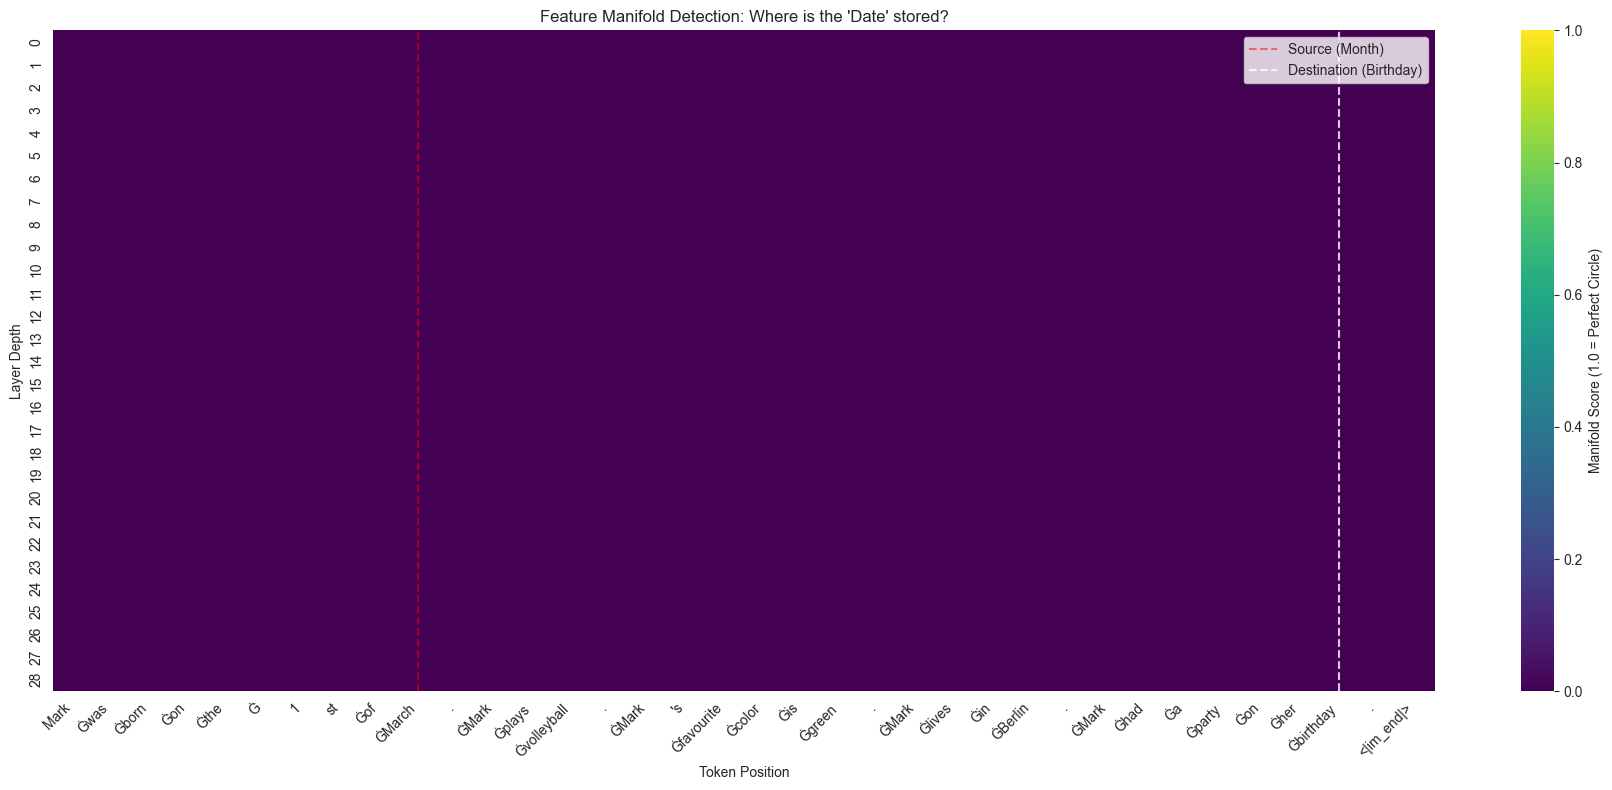

In [8]:
import seaborn as sns

# Create the plot
plt.figure(figsize=(18, 8))

# HEATMAP CONFIGURATION
sns.heatmap(
    stress_map,
    cmap="viridis",
    vmin=0, vmax=1,  # Anchor scale between 0 and 1
    cbar_kws={'label': 'Manifold Score (1.0 = Perfect Circle)'}
)

# Labeling X-axis
sample_tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
plt.xticks(
    ticks=np.arange(len(sample_tokens)) + 0.5,
    labels=sample_tokens,
    rotation=45,
    ha='right'
)

plt.xlabel("Token Position")
plt.ylabel("Layer Depth")
plt.title("Feature Manifold Detection: Where is the 'Date' stored?")

# Highlight Hypothesis Areas
month_label_pos = indices["Source (Month)"] + 0.5
birthday_label_pos = indices["Destination (Birthday)"] + 0.5
plt.axvline(x=month_label_pos, color='red', linestyle='--', alpha=0.5, label='Source (Month)')
plt.axvline(x=birthday_label_pos, color='white', linestyle='--', alpha=0.8, label='Destination (Birthday)')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

#### We also plot the Manifold Integrity (Stress) as a line graph.

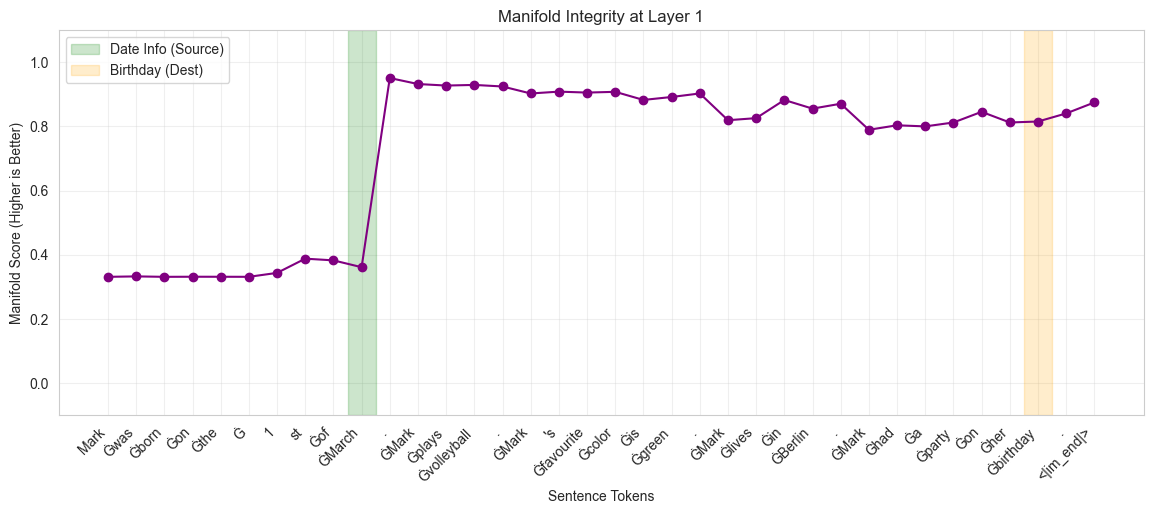

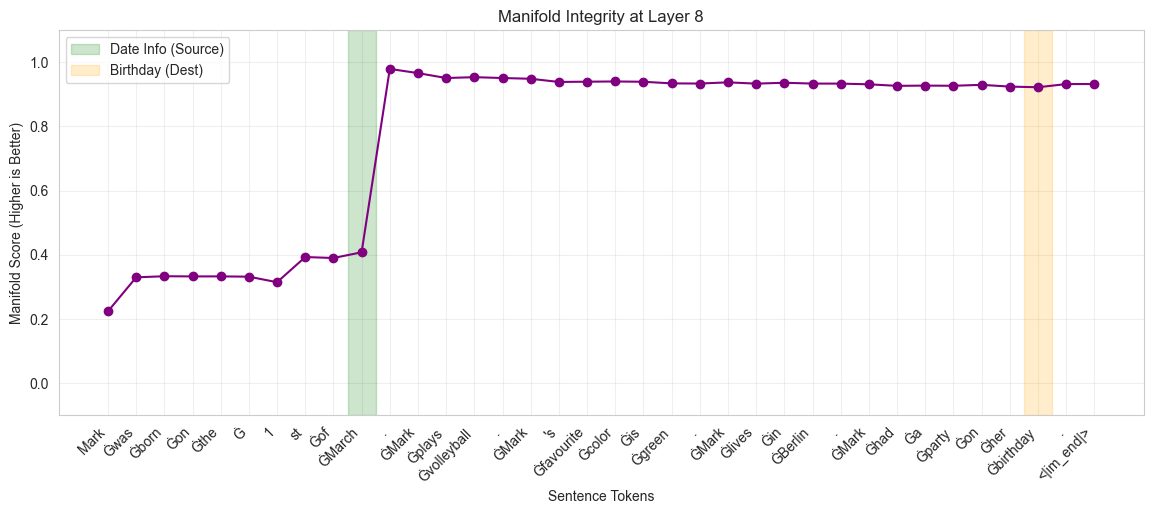

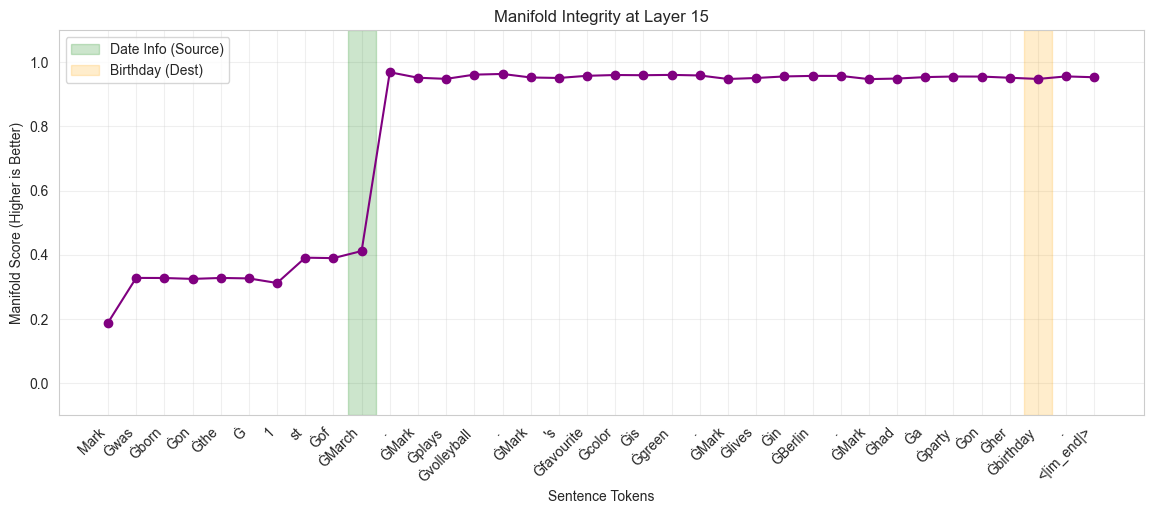

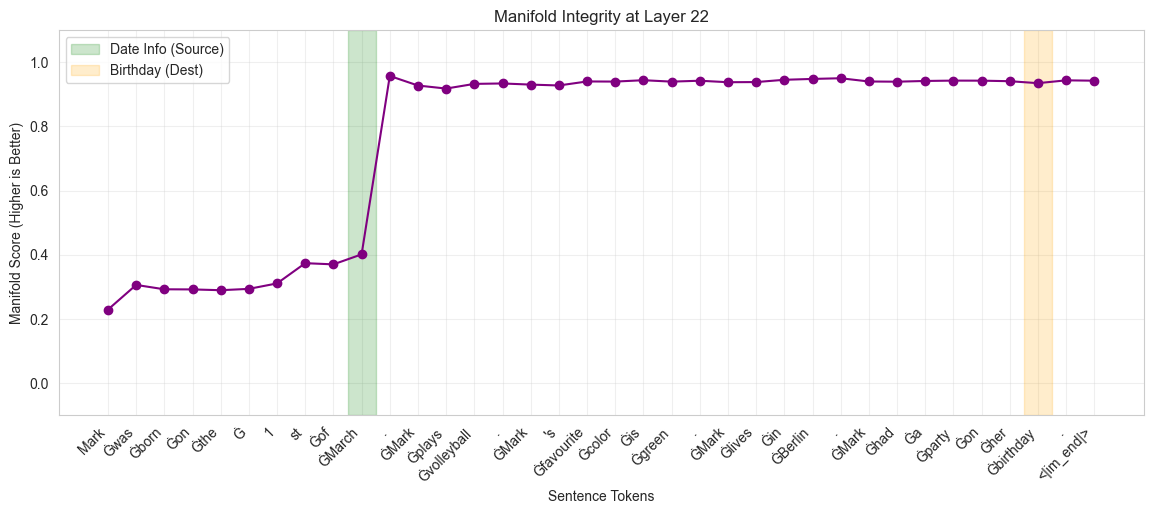

In [18]:
target_layer = 28

for i in range(target_layer):
    if i%7 == 1:
        plt.figure(figsize=(14, 5))
        plt.plot(stress_map[i, :], marker='o', linestyle='-', color='purple')

        # Add Labels
        plt.xticks(
            ticks=np.arange(len(sample_tokens)),
            labels=sample_tokens,
            rotation=45,
            ha='right'
        )

        plt.ylabel("Manifold Score (Higher is Better)")
        plt.ylim(-0.1, 1.1) # Fix y-axis to see the 0-1 range clearly
        plt.xlabel("Sentence Tokens")
        plt.title(f"Manifold Integrity at Layer {i}")
        plt.grid(True, alpha=0.3)

        # Highlight zones
        plt.axvspan(month_label_pos-1, month_label_pos, color='green', alpha=0.2, label="Date Info (Source)")
        plt.axvspan(birthday_label_pos-1, birthday_label_pos, color='orange', alpha=0.2, label="Birthday (Dest)")
        plt.legend()

        plt.show()

## Try orthonormal = False

We now relax the constraint to allow general **Linear Projections** (including scaling and shearing). This effectively asks: *"Can the data be stretched or squashed to look like a circle?"* While this allows us to detect distorted manifolds, it also increases the degrees of freedom, making the method more susceptible to finding patterns in noise.

In [10]:
from smds import SupervisedMDS
from smds.shapes.continuous_shapes import CircularShape
from sklearn.model_selection import KFold
import numpy as np

# Initialize storage
n_layers = X_activations.shape[1]
n_tokens = X_activations.shape[2]
stress_map = np.zeros((n_layers, n_tokens))

print(f"Running Cross-Validated SMDS on {n_layers} layers and {n_tokens} tokens...")

shape_hypothesis = CircularShape()

# Setup Cross-Validation (5 Folds is standard)
# shuffle=True ensures we don't accidentally just pick the first 200 days
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for layer in tqdm(range(n_layers), desc="Layers"):
    for token in range(n_tokens):

        # 1. Isolate Data
        # Cast to float32 to prevent potential issues with mixed precision
        X_location = X_activations[:, layer, token, :].astype(np.float32)

        # Storage for the score of each fold
        fold_scores = []

        # 2. Run Cross-Validation Loop
        try:
            for train_idx, test_idx in kf.split(X_location):
                # Split Data
                X_train, X_test = X_location[train_idx], X_location[test_idx]
                y_train, y_test = y_labels[train_idx], y_labels[test_idx]

                # Initialize
                reducer = SupervisedMDS(
                    manifold=shape_hypothesis,
                    n_components=2
                )

                # FIT on Training Set
                reducer.fit(X_train, y_train)

                # SCORE on Test Set (The crucial step!)
                # This measures how well the manifold generalizes to unseen data
                score = reducer.score(X_test, y_test)

                # Clip to valid range [0, 1] just in case
                fold_scores.append(max(0.0, min(1.0, score)))

            # 3. Average the Test Scores
            # If the manifold is real, this average will be high.
            # If it was overfitting noise, this will drop to ~0.
            stress_map[layer, token] = np.mean(fold_scores)

        except Exception as e:
            stress_map[layer, token] = 0.0

print("Analysis Complete.")

Running Cross-Validated SMDS on 29 layers and 36 tokens...


Layers: 100%|██████████| 29/29 [1:02:07<00:00, 128.54s/it]

Analysis Complete.


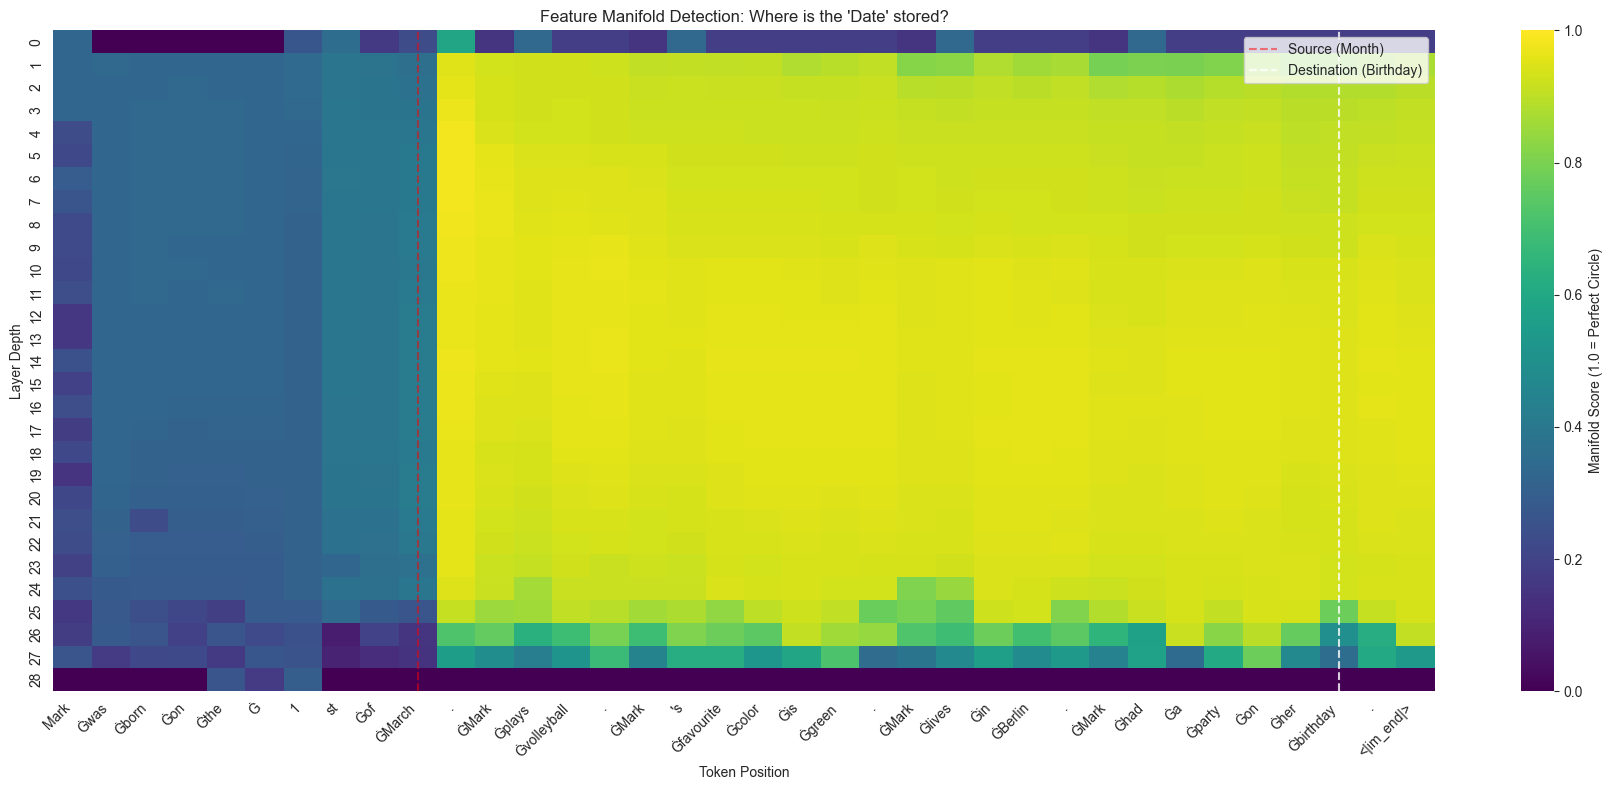

In [11]:
import seaborn as sns

# Create the plot
plt.figure(figsize=(18, 8))

# HEATMAP CONFIGURATION
sns.heatmap(
    stress_map,
    cmap="viridis",
    vmin=0, vmax=1,  # Anchor scale between 0 and 1
    cbar_kws={'label': 'Manifold Score (1.0 = Perfect Circle)'}
)

# Labeling X-axis
sample_tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
plt.xticks(
    ticks=np.arange(len(sample_tokens)) + 0.5,
    labels=sample_tokens,
    rotation=45,
    ha='right'
)

plt.xlabel("Token Position")
plt.ylabel("Layer Depth")
plt.title("Feature Manifold Detection: Where is the 'Date' stored?")

# Highlight Hypothesis Areas
month_label_pos = indices["Source (Month)"] + 0.5
birthday_label_pos = indices["Destination (Birthday)"] + 0.5
plt.axvline(x=month_label_pos, color='red', linestyle='--', alpha=0.5, label='Source (Month)')
plt.axvline(x=birthday_label_pos, color='white', linestyle='--', alpha=0.8, label='Destination (Birthday)')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

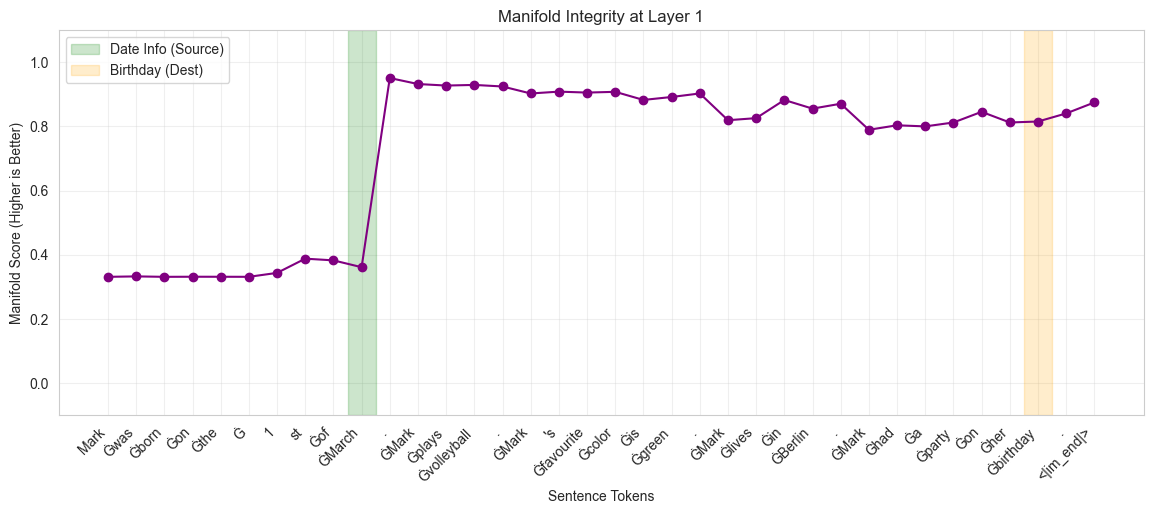

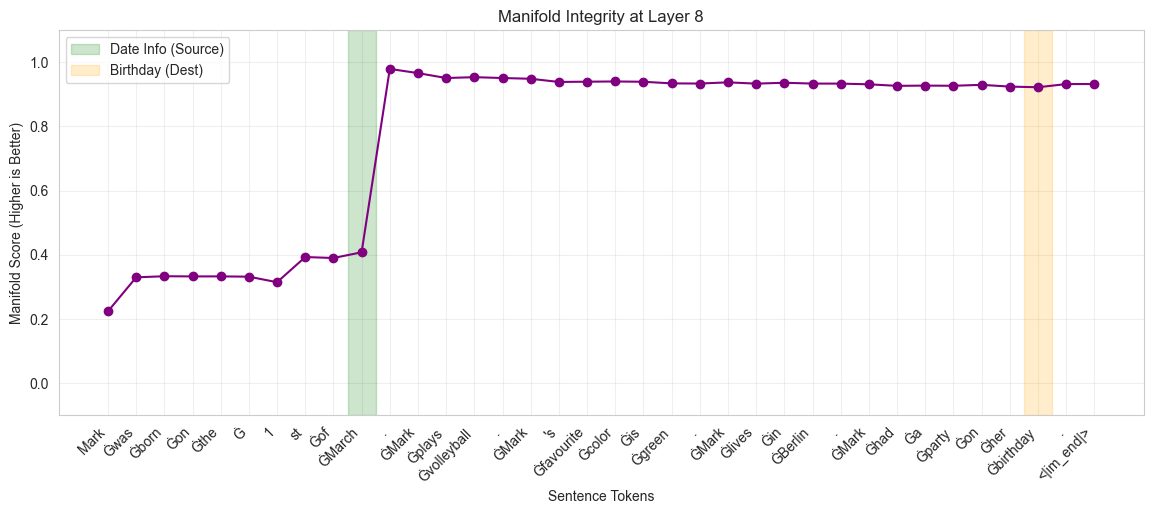

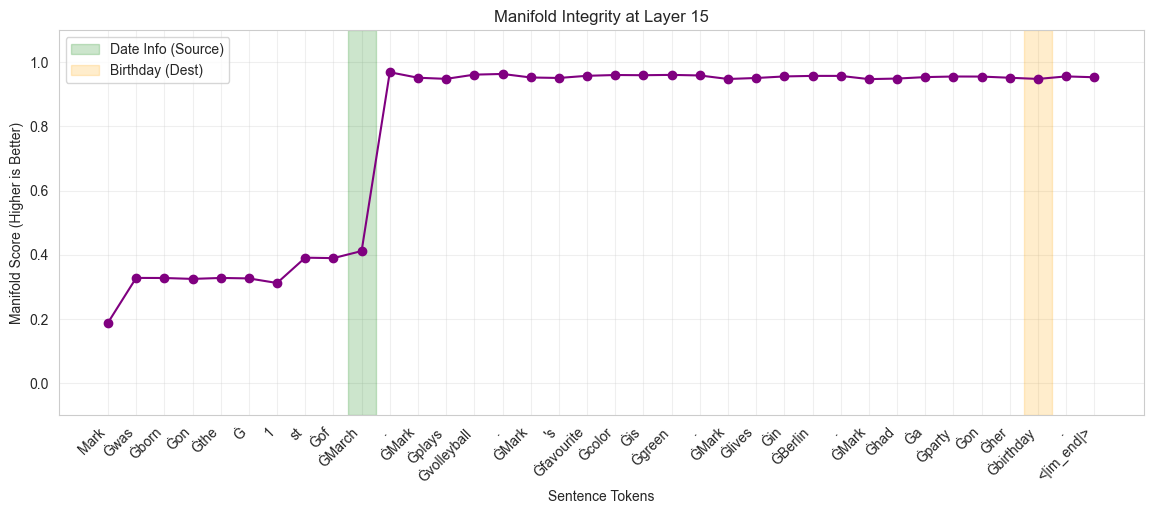

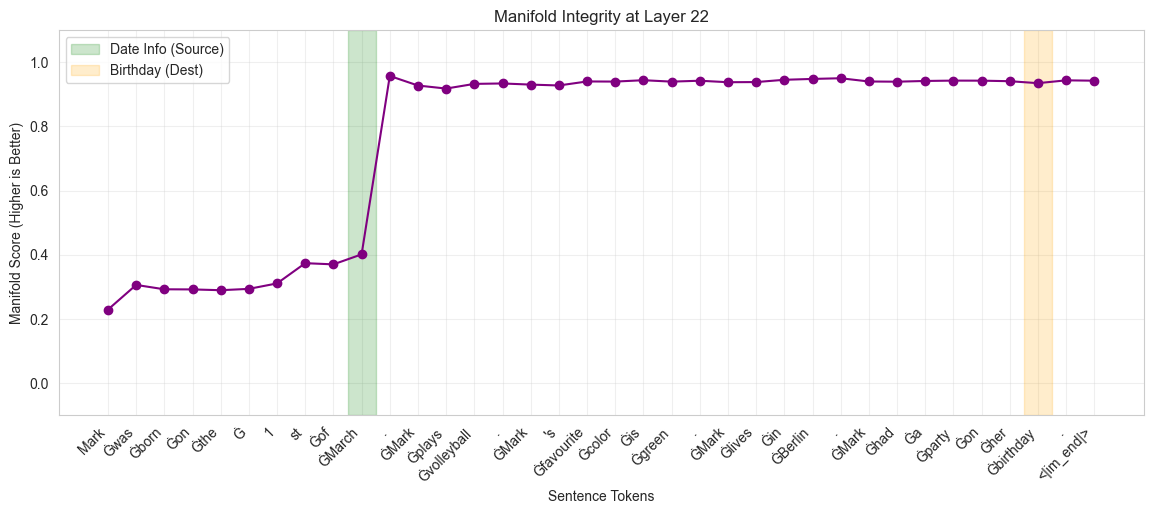

In [19]:
target_layer = 28

for i in range(target_layer):
    if i%7 == 1:
        plt.figure(figsize=(14, 5))
        plt.plot(stress_map[i, :], marker='o', linestyle='-', color='purple')

        # Add Labels
        plt.xticks(
            ticks=np.arange(len(sample_tokens)),
            labels=sample_tokens,
            rotation=45,
            ha='right'
        )

        plt.ylabel("Manifold Score (Higher is Better)")
        plt.ylim(-0.1, 1.1) # Fix y-axis to see the 0-1 range clearly
        plt.xlabel("Sentence Tokens")
        plt.title(f"Manifold Integrity at Layer {i}")
        plt.grid(True, alpha=0.3)

        # Highlight zones
        plt.axvspan(month_label_pos-1, month_label_pos, color='green', alpha=0.2, label="Date Info (Source)")
        plt.axvspan(birthday_label_pos-1, birthday_label_pos, color='orange', alpha=0.2, label="Birthday (Dest)")
        plt.legend()

        plt.show()

# Experiment: Pairwise Geometric Alignment

**Objective:**
To verify that the circular geometry found at the Destination ("Birthday") is semantically identical to the one at the Source ("March"), accounting for potential rotations.

**Methodology:**
1.  **Independent Projection:** For every token $t$, we independently learn its best mapping $W_t$ to project activations into a 2D point cloud $Y_t$.
2.  **Procrustes Analysis:** We compare the point cloud of Token $A$ ($Y_A$) against Token $B$ ($Y_B$). The algorithm attempts to optimally **translate, scale, and rotate** $Y_B$ to overlay it onto $Y_A$.
3.  **Disparity Score:** We calculate how well they fit after alignment.
    $$ \text{Alignment} = 1.0 - \sum (Y_A - Y_{B,rotated})^2 $$

**Interpretation:**
*   **High Alignment (Bright):** The two tokens contain the **same semantic information** (the same circle), even if the model rotated the subspace between layers.
*   **Low Alignment (Dark):** The geometric shapes are fundamentally different (e.g., one is a date circle, the other is a random noise blob).

In [20]:
from scipy.spatial import procrustes
from smds import SupervisedMDS
from smds.shapes.continuous_shapes import CircularShape
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

# --- CONFIGURATION ---
TARGET_LAYER = 20
print(f">>> Analyzing Alignment at Layer {TARGET_LAYER}...")

# --- 1. COLLECT MANIFOLDS (Y) ---
n_tokens = X_activations.shape[2]
projections = []
shape_hypothesis = CircularShape()

print("Generating Manifolds...")
for token in tqdm(range(n_tokens)):
    X_loc = X_activations[:, TARGET_LAYER, token, :].astype(np.float32)

    # Normalize
    scaler = StandardScaler()
    X_loc = scaler.fit_transform(X_loc)

    # Fit SMDS
    reducer = SupervisedMDS(manifold=shape_hypothesis, n_components=2)
    try:
        Y_loc = reducer.fit_transform(X_loc, y_labels)
        projections.append(Y_loc)
    except Exception:
        projections.append(np.zeros((X_loc.shape[0], 2)))

# --- 2. COMPUTE ALIGNMENT ---
alignment_matrix = np.zeros((n_tokens, n_tokens))

print("Computing Procrustes...")
for i in tqdm(range(n_tokens)):
    for j in range(n_tokens):
        if i == j:
            continue  # mask diagonal later

        Y_a = projections[i]
        Y_b = projections[j]

        if np.var(Y_a) < 1e-6 or np.var(Y_b) < 1e-6:
            alignment_matrix[i, j] = 0.0
            continue

        try:
            _, _, disparity = procrustes(Y_a, Y_b)
            alignment_matrix[i, j] = max(0.0, 1.0 - disparity)
        except Exception:
            alignment_matrix[i, j] = 0.0



>>> Analyzing Alignment at Layer 20...
Generating Manifolds...


100%|██████████| 36/36 [01:00<00:00,  1.67s/it]


Computing Procrustes...


100%|██████████| 36/36 [00:00<00:00, 516.99it/s]


### Visualization

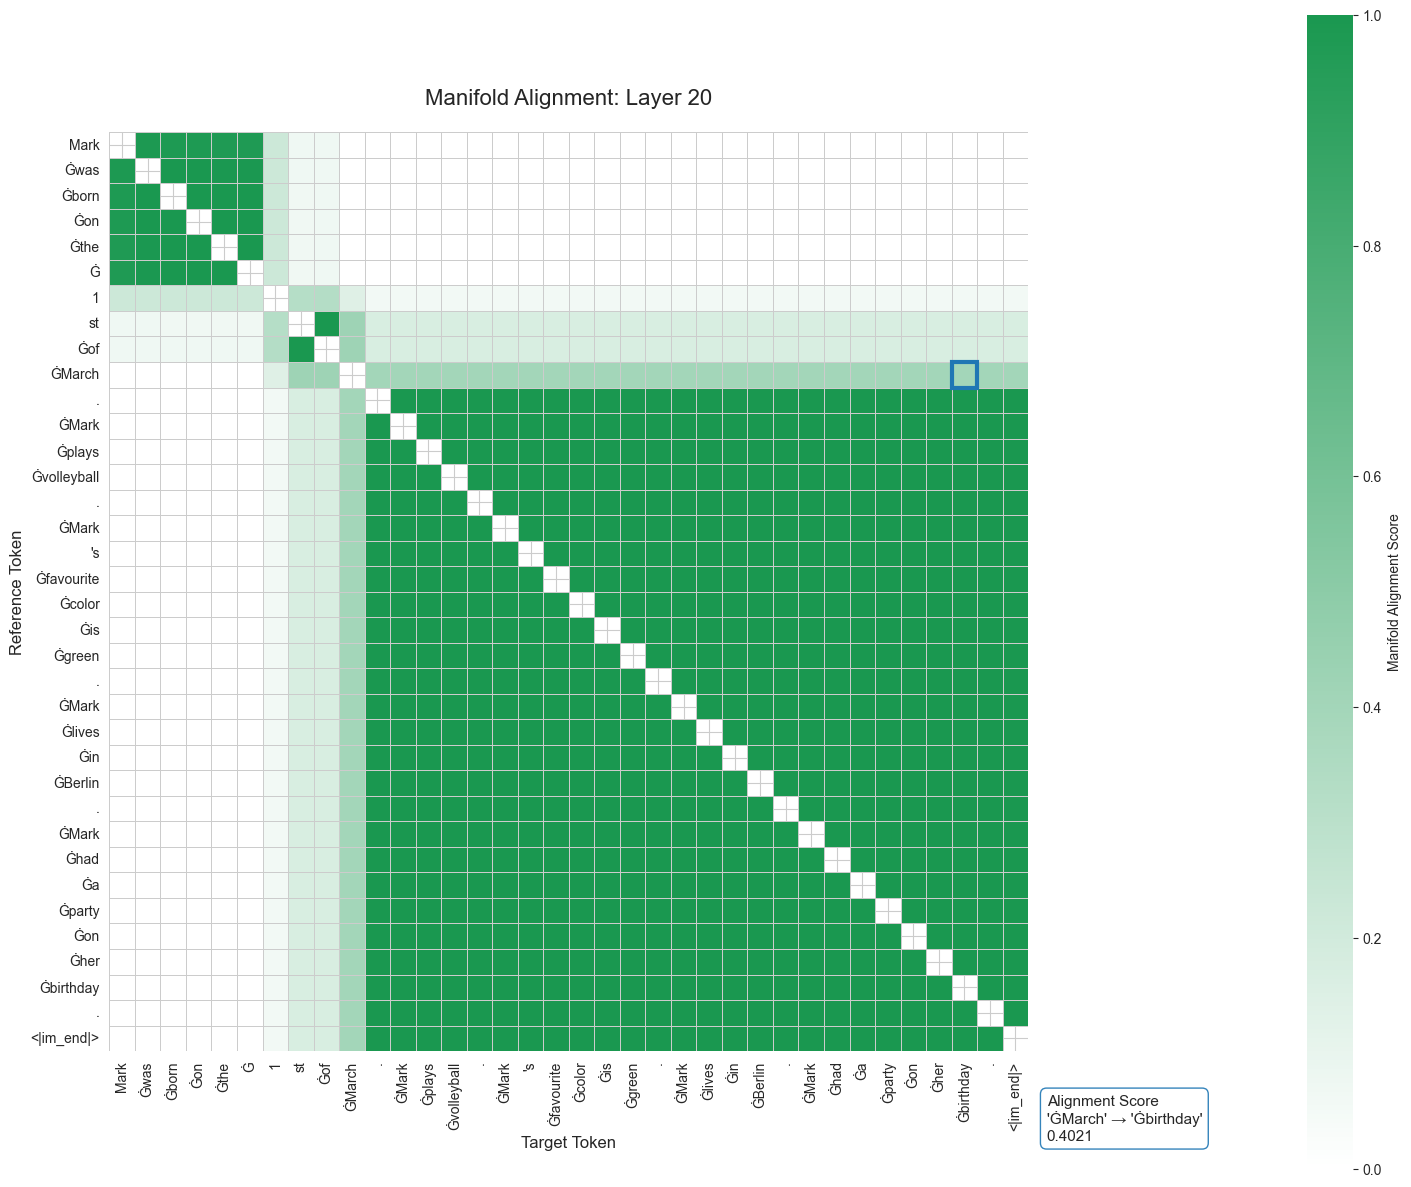

In [21]:
from matplotlib.colors import LinearSegmentedColormap
# Mask diagonal
mask = np.eye(n_tokens, dtype=bool)

alignment_matrix[alignment_matrix < 0.05] = 0.0



ryg = LinearSegmentedColormap.from_list(
    "red_yellow_green",
    [
        (0.0,  "#FFFFFF"),  # white
        (1.0,  "#1a9850"),  # green
    ]
)


# Figure + dedicated colorbar axis
fig = plt.figure(figsize=(14, 12), constrained_layout=True)
gs = fig.add_gridspec(1, 2, width_ratios=[20, 1], wspace=0.15)

ax = fig.add_subplot(gs[0, 0])
cax = fig.add_subplot(gs[0, 1])

sns.heatmap(
    alignment_matrix,
    mask=mask,
    xticklabels=viz_labels,
    yticklabels=viz_labels,
    cmap=ryg,
    vmin=0, vmax=1,
    square=True,
    linewidths=0.4,
    linecolor="#cccccc",
    cbar=True,
    cbar_ax=cax,
    cbar_kws={'label': 'Manifold Alignment Score'},
    ax=ax
)

ax.set_title(f"Manifold Alignment: Layer {TARGET_LAYER}", fontsize=16, pad=20)
ax.set_xlabel("Target Token", fontsize=12)
ax.set_ylabel("Reference Token", fontsize=12)



# --- Highlight Specific Interaction ---
idx_src = indices["Source (Month)"]
idx_dest = indices["Destination (Birthday)"]

if idx_src != -1 and idx_dest != -1:
    rect = Rectangle(
        (idx_dest, idx_src),
        1, 1,
        fill=False,
        edgecolor="#1f77b4",  # blue
        lw=3,
        zorder=10
    )
    ax.add_patch(rect)

    score = alignment_matrix[idx_src, idx_dest]

    ax.text(
        1.02, -0.1,
        f"Alignment Score\n"
        f"'{viz_labels[idx_src]}' → '{viz_labels[idx_dest]}'\n"
        f"{score:.4f}",
        transform=ax.transAxes,
        fontsize=11,
        va='bottom',
        ha='left',
        bbox=dict(
            facecolor='white',
            alpha=0.9,
            edgecolor="#1f77b4",
            boxstyle='round,pad=0.4'
        )
    )

plt.show()

# Experiment: Subspace Reuse (One-Shot Projection)

**Objective:**
To determine if the "Date" information is stored in a **stable linear subspace** across the sentence.

**Methodology:**
Unlike the previous analysis where we trained a new projection for every token, here we enforce a constraint:
1.  **Train ($W_{source}$):** We learn the projection matrix $W$ **only** on the Source Token (e.g., "March"). This identifies the "Native Date Subspace."
2.  **Apply:** We apply this exact $W_{source}$ to **every other token** in the sentence.
    $$ \text{Score}_{token} = \text{SMDS\_Score}(X_{token} \cdot W_{source}, \text{Labels}) $$

**Interpretation:**
*   **High Score:** The model "copied" the date vector directly. The information exists in the *exact same location and orientation* in the residual stream.
*   **Low Score:** The information is either missing, or it has been **rotated/transformed** into a different subspace (even if the geometry is preserved).

In [15]:
from smds import SupervisedMDS
from smds.shapes.continuous_shapes import CircularShape # explicit import as requested
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

# --- CONFIGURATION ---
# We need to know which token is the "Teacher" (Source)
source_idx = indices["Source (Month)"]
dest_idx = indices["Destination (Birthday)"]

print(f">>> Training on Source: '{viz_labels[source_idx]}' (Index {source_idx})")
print(">>> applying projection to all other tokens...")

# Initialize storage
n_layers = X_activations.shape[1]
n_tokens = X_activations.shape[2]
reuse_score_map = np.zeros((n_layers, n_tokens))

shape_hypothesis = CircularShape()

# Loop through Layers
for layer in tqdm(range(n_layers), desc="Projecting Layers"):

    # 1. PREPARE SOURCE DATA (The Teacher)
    # Cast to float32 for stability
    X_source = X_activations[:, layer, source_idx, :].astype(np.float32).copy()

    # Normalize Source
    # We maintain a separate scaler for the source to learn the "Ideal" distribution
    scaler_source = StandardScaler()
    X_source_norm = scaler_source.fit_transform(X_source)

    # 2. TRAIN SMDS (Learn W)
    # We find the projection that turns the Source Token into a Circle
    # orthonormal=False allows for scaling/skewing, simpler for this check
    projector = SupervisedMDS(
        manifold=shape_hypothesis,
        n_components=2
    )

    try:
        projector.fit(X_source_norm, y_labels)
    except Exception as e:
        # If source fails (e.g. layer 0 noise), skip layer
        continue

    # 3. TEST ON ALL TOKENS (The Students)
    for token in range(n_tokens):
        # Prepare Target Data
        X_target = X_activations[:, layer, token, :].astype(np.float32).copy()

        # Normalize Target
        # Critical Decision: We fit a NEW scaler for the target.
        # Why? We want to test if the DIRECTION (W) is valid.
        # We don't want to penalize the token just because its mean/variance shifted.
        scaler_target = StandardScaler()
        X_target_norm = scaler_target.fit_transform(X_target)

        # 4. REUSE PROJECTION
        # We do NOT call .fit(). We only call .score().
        # This uses the W learned from the Source.
        try:
            score = projector.score(X_target_norm, y_labels)

            # Clip for cleaner plotting
            score = max(0.0, min(1.0, score))
            reuse_score_map[layer, token] = score
        except:
            reuse_score_map[layer, token] = 0.0

>>> Training on Source: 'ĠMarch' (Index 9)
>>> applying projection to all other tokens...


Projecting Layers: 100%|██████████| 29/29 [01:24<00:00,  2.91s/it]


### Verdict

We compare the score at the Destination using the Source's projection vs the Source's own score.

In [29]:
best_layer = np.argmax(reuse_score_map[:, source_idx+1])
src_score = reuse_score_map[best_layer, source_idx]
dest_score = reuse_score_map[best_layer, dest_idx] if dest_idx != -1 else 0

print("\n--- SUBSPACE ALIGNMENT VERDICT ---")
print(f"Best Layer for Source: {best_layer}")
print(f"Source Self-Score    : {src_score:.4f}")
print(f"Destination Score    : {dest_score:.4f}")

if dest_score > 0.8:
    print("✅ ALIGNED: The model copies the vector DIRECTLY.")
    print("   The 'Birthday' token uses the exact same subspace direction as 'Month'.")
elif dest_score > 0.2:
    print("⚠️ ROTATED: The information is present but transformed.")
    print("   The previous experiment found a circle, but this one failed.")
    print("   This implies the model rotated the representation between Source and Dest.")
else:
    print("❌ MISALIGNED: The subspaces are completely different.")


--- SUBSPACE ALIGNMENT VERDICT ---
Best Layer for Source: 15
Source Self-Score    : 0.4588
Destination Score    : 0.3385
⚠️ ROTATED: The information is present but transformed.
   The previous experiment found a circle, but this one failed.
   This implies the model rotated the representation between Source and Dest.


### Visualization

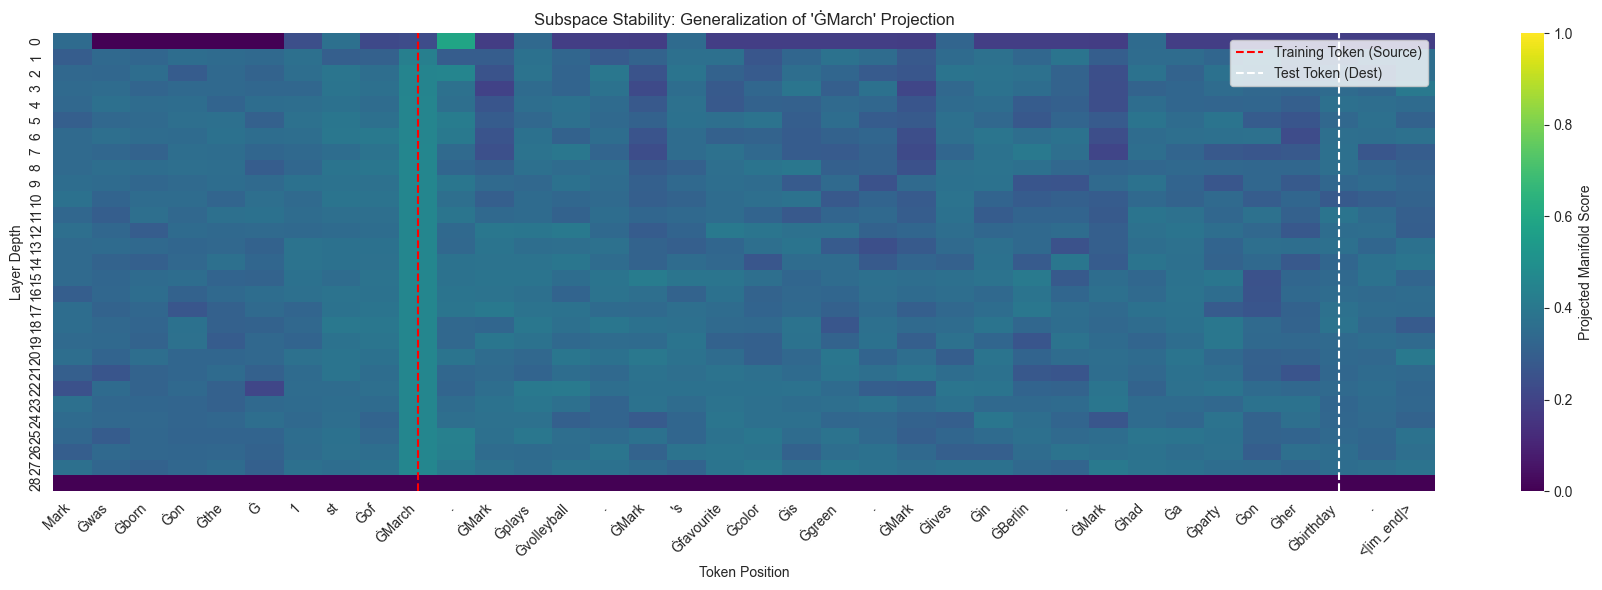

In [30]:
plt.figure(figsize=(18, 6))
sns.heatmap(
    reuse_score_map,
    cmap="viridis",
    vmin=0, vmax=1,
    cbar_kws={'label': 'Projected Manifold Score'}
)

plt.xticks(ticks=np.arange(n_tokens)+0.5, labels=viz_labels, rotation=45, ha='right')
plt.title(f"Subspace Stability: Generalization of '{viz_labels[source_idx]}' Projection")
plt.xlabel("Token Position")
plt.ylabel("Layer Depth")

# Highlight columns
plt.axvline(source_idx+0.5, color='red', linestyle='--', label='Training Token (Source)')
if dest_idx != -1:
    plt.axvline(dest_idx+0.5, color='white', linestyle='--', label='Test Token (Dest)')

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Experiment Summary & Analysis

#### <u>Observation: Sensitivity to Geometric Constraints</u>
When applying strict **Orthogonal constraints**, the manifold scores dropped significantly (no structure found). This indicates that the feature representation is **not** stored as a rigid, undeformed circle. The high scores appear only when the method is allowed to stretch and skew the data freely.

#### <u>Observation: Ubiquitous Manifold Structure</u>

In the **Independent Projection** analysis, we observed extremely high manifold scores ($> 0.95$) across the entire sentence context following the mention of the date. Crucially, this high score appears on **all tokens**, including semantic distractors (e.g., "volleyball", "green") and the target destination ("birthday").

#### <u>Observation: Indistinguishability of Target</u>

The "Birthday" token does **not** exhibit a statistically significant higher score compared to random distractor tokens.
*   *Max Score (Distractor):* ~0.99
*   *Max Score (Birthday):* ~0.99
*   *Verdict:* Under this method, the "Birthday" token is not special.

#### <u>Observation: Subspace Instability</u>

The **Subspace Reuse** experiment demonstrates that the linear projection $W$ learned at the Source ("Month") does *not* generalize to subsequent tokens (Score $< 0.4$). This confirms that the specific linear subspace representing the date at the source is not maintained throughout the sentence.

#### <u>Observation: Geometric Alignment</u>
The **Procrustes Analysis** shows high geometric alignment ($> 0.9$) between the Source manifold and the manifolds found at *all* subsequent tokens.

# Conclusion

The combination of **High Independent Scores** everywhere and **High Alignment** everywhere, but **Low Subspace Reuse**, points to two possible interpretations:

1.  **The Overfitting Hypothesis:**
    The SMDS method, when applied to high-dimensional hidden states ($D=768$) with a limited sample size ($N=1000$), possesses enough degrees of freedom to find a "circular" projection in almost any noise distribution. The fact that "volleyball" scores nearly $1.0$ suggests the method is detecting random noise patterns rather than semantic signal.

2.  **The Context Smearing Hypothesis:**
    The model, lacking the capacity for precise "Just-in-Time" retrieval, may be maintaining the date information in its residual stream globally (smearing). However, given the perfect scores on clearly irrelevant tokens, **Overfitting** remains the more probable explanation for the uniformity of the results.